# Biological network construction and basic topology analysis

## Objectives:
* Constructing integrated omics graph involving metabolites quantifications and gene expression.
* Conducting the basic analysis for the obtained graph.
* Discussing further stepts on the graph analysis.

## Utility functions

In [ ]:
def squared2long(mat, col='p_val'):
  #Convert p-value matrix to the list-like form:
  mat_ = mat.where(np.triu(np.ones(mat.shape), 1).astype(bool))
  mat_.columns.name='Feat2'
  mat_ = mat_.stack()
  mat_.index.names=['v1','v2'] #Avoid stacked names colliding
  mat_ = mat_.reset_index()
  mat_.columns = ['feat1','feat2',col]
  return mat_

In [ ]:
def long2square(rho_p_mat):
  PRQ = pd.concat([rho_p_mat.copy(),
                 rho_p_mat.copy().rename(columns={'feat1':'feat2','feat2':'feat1'}).loc[:,rho_p_mat.columns]
                 ]).drop_duplicates()

  rho_fdr = PRQ.copy().pivot(index='feat1',columns='feat2',values='R (fdr)')
  rho_fdr = rho_fdr.loc[rho_fdr.sum()!=0]
  rho_p_adj = PRQ.copy().pivot(index='feat1',columns='feat2',values='R (p_adj)')
  rho_fdr = rho_fdr.loc[rho_fdr.index,rho_fdr.index].fillna(0)
  rho_p_adj = rho_p_adj.loc[rho_p_adj.index,rho_p_adj.index].fillna(0)
  return rho_fdr, rho_p_adj

In [ ]:
def add_scores_to_one_table(rho_mat_, p_mat_, p_adj, fdr):
  p_mat_ = pd.concat([p_mat_, p_adj], axis=1)
  p_mat_ = pd.concat([p_mat_, fdr], axis=1)
  rho_p_mat = pd.merge(rho_mat_.copy(),
                        p_mat_.copy(),
                        on=['feat1','feat2']) #Correlation matrix with both R and p
  rho_p_mat = rho_p_mat.loc[rho_p_mat.feat1!=rho_p_mat.feat2].dropna()
  return rho_p_mat

In [ ]:
def add_interaction_type(rho_p_mat, df_type):
  all_mets = df_type.loc[df_type.Type=='met'].index
  rho_p_mat['feat1_type'] = ['met' if x in all_mets else 'gene' for x in rho_p_mat.feat1 ]
  rho_p_mat['feat2_type'] = ['met' if x in all_mets else 'gene' for x in rho_p_mat.feat2 ]
  rho_p_mat['int_type'] = rho_p_mat.feat1_type+'_' + rho_p_mat.feat2_type
  return rho_p_mat

In [ ]:
def knn_sub_graph(knnG):
  #random subset of knn graph for plotting
  short_knn=ig.Graph.TupleList([tuple(x) for x in knnG.values[random.sample(list(np.arange(len(knnG.values))), 5000)]], directed=False)

  #This plots each graph, using degree to present node size:
  short_knn.vs['degree']=short_knn.degree()
  short_knn.vs['degree_size']=[(x*15)/(max(short_knn.vs['degree'])) for x in short_knn.vs['degree']] #degree is multiplied by 10 so that we can see all nodes
  return short_knn

## Import necessary libraries

In [ ]:
#install the packages:
!pip3 install igraph -q
!pip3 install leidenalg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:00


In [ ]:
#import the libraries:

#a library for machine learning
import sklearn
#importing k-nearest neighbors methods
import sklearn.neighbors
#importing the scaler
from sklearn.preprocessing import StandardScaler
#a library for generating pseudo random values
import random
#a package for analysing datasets, so-called dataframes
import pandas as pd
#a library for optimized scientific computation, work with matrices, etc.
import numpy as np
#Network analysis software, networkx as an alternative software
import igraph as ig
#The software for statistical analysis
import scipy as sp
#An way to run multiple testing on Python
from statsmodels.stats.multitest import multipletests
#algorythm for detecting communities in the graph
import leidenalg

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.setrecursionlimit(1500)
#Pictures rendering
%matplotlib inline

## Getting to know the data




In [ ]:
df = pd.read_csv('https://github.com/Olga013/ds_in_ls/blob/main/presentation/data/met_genes.tsv?raw=true', sep="\t", index_col=0)

#### Question
What should we do before we start analysing the data?

In [ ]:
# @title
#Check if there is no duplicated features:
any(df.index.duplicated())

False

In [ ]:
# @title
#Check if we have missing values or not
df.isna().any().any()

np.False_

In [ ]:
# @title
#Check how many different genes/metabolites are in the dataset
df.groupby('Type').agg('count')[['p10']]

p10
Type       
genes  1992
met     125

## Association analysis

###Spearman correlation

In [ ]:
values = df.loc[:, df.columns!='Type']
df_type = df[['Type']]

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


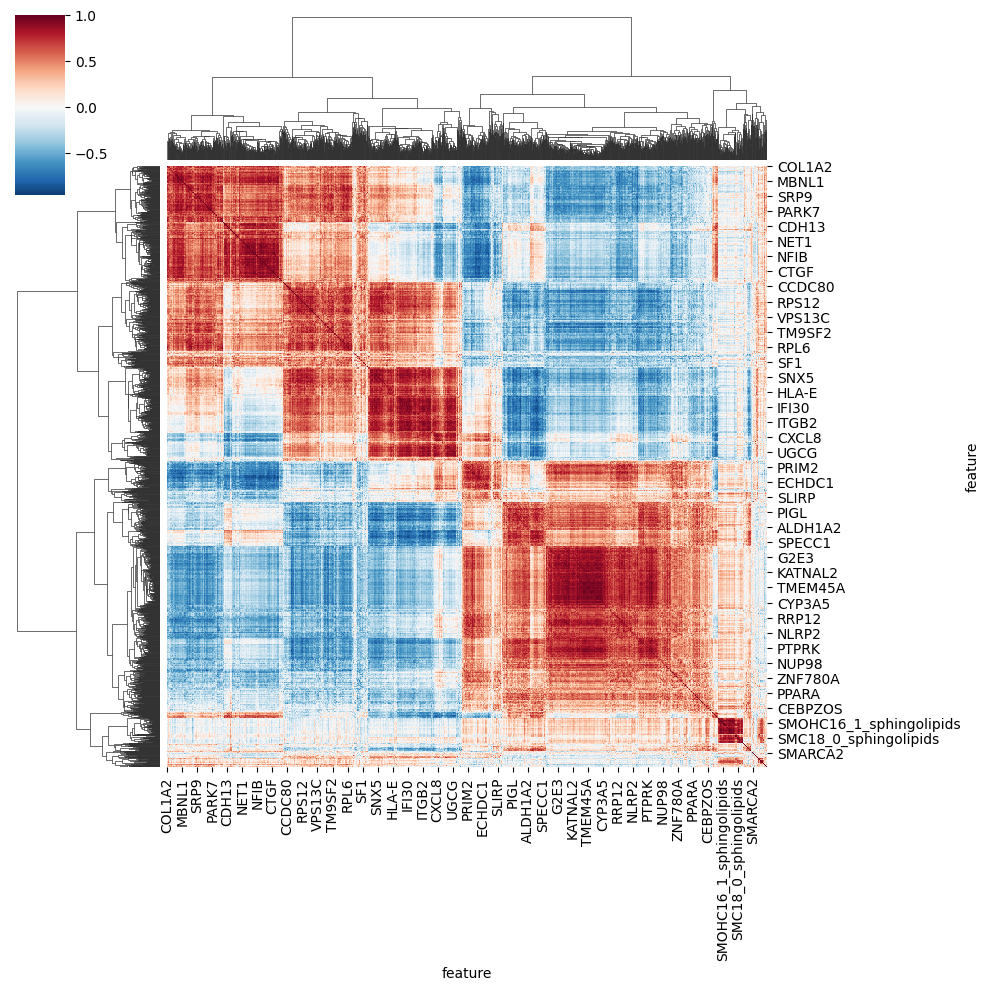

In [ ]:
#Correlation and P val matrices
rho_mat, p_mat = sp.stats.spearmanr(values.T)
rho_mat = pd.DataFrame(rho_mat,
                       index=values.index.copy(),
                       columns=values.index.copy())
p_mat = pd.DataFrame(p_mat,
                     index=values.index.copy(),
                     columns=values.index.copy())

#plot the heatmap based on correlation values
sns.clustermap(rho_mat, cmap="RdBu_r", center=0);

#### **Question**
Can you evaluate the probability of finding at least one $F_p$ during after performing comparisons of $2117$ variables? (We have $\alpha^*=0.01$ for all comparisons).

<details>
<summary>Solution:</summary>

$v = 2117$

$n_{corr} = \frac{v*(v-1)}{2} = \frac{2117 * (2117 - 1)}{2} = 2 * 10^6$ correlations

The probability for FWER:  $1 - (1 - \alpha^*)^m = 1 - 0.99^{(2*10^6)} \approx 1$
</details>

### Adjustments

In [ ]:
#Convert p-value and R matrices to the list-like form:
p_mat_ = squared2long(p_mat, col='p_val')
rho_mat_ = squared2long(rho_mat, col='R')

In [ ]:
p_mat_

feat1                   feat2         p_val
0        C0_accarnitines         C2_accarnitines  7.071768e-02
1        C0_accarnitines         C3_accarnitines  9.329101e-03
2        C0_accarnitines  C3DC_C4OH_accarnitines  5.584781e-02
3        C0_accarnitines  C5DC_C6OH_accarnitines  8.896314e-01
4        C0_accarnitines      C5MDC_accarnitines  5.207955e-01
...                  ...                     ...           ...
2239781           ATP5PB                   CPED1  9.164870e-01
2239782           ATP5PB                 SLCO2B1  8.027130e-03
2239783           MGAT4A                   CPED1  3.068652e-02
2239784           MGAT4A                 SLCO2B1  3.726899e-07
2239785            CPED1                 SLCO2B1  9.336096e-03

[2239786 rows x 3 columns]

In [ ]:
#Multiple hypothesis correction computed on the P column
p_adj = pd.DataFrame(multipletests(p_mat_['p_val'],
                                   method='bonferroni',
                                   alpha=0.01)[1],
                                   columns=['p_val_adj'])

fdr = pd.DataFrame(multipletests(p_mat_['p_val'],
                                 method='fdr_bh',
                                 alpha=0.01)[1],
                                 columns=['FDR'])

### Collect all the data into one table

In [ ]:
rho_p_mat = add_scores_to_one_table(rho_mat_, p_mat_, p_adj, fdr)

In [ ]:
print('Total number of correlations w/o repetition: %s (the same as we estimated)' % rho_p_mat.shape[0])

Total number of correlations w/o repetition: 2239786 (the same as we estimated)


In [ ]:
#Let's add two additional columns, where we assign R=0 for those correlations
#that are not statistically significant (p_val_adj > 0.01, and FDR > 0.01) for the plot.
rho_p_mat.loc[:,'R (p_adj)'] = rho_p_mat['R'].copy()
rho_p_mat.loc[:,'R (fdr)'] = rho_p_mat['R'].copy()
rho_p_mat.loc[rho_p_mat['p_val_adj']>0.01,'R (p_adj)'] = 0
rho_p_mat.loc[rho_p_mat['FDR']>0.01,'R (fdr)'] = 0

In [ ]:
#Add the type of interactions (gene-gene, gene-met, met-met)
rho_p_mat = add_interaction_type(rho_p_mat.copy(), df_type)
rho_p_mat.to_csv('association_matrix.tsv', sep="\t", index=False) #export correlation matrix for faster loading

In [ ]:
rho_p_mat.head()

feat1                   feat2         R     p_val  p_val_adj  \
0  C0_accarnitines         C2_accarnitines  0.375326  0.070718        1.0   
1  C0_accarnitines         C3_accarnitines  0.519174  0.009329        1.0   
2  C0_accarnitines  C3DC_C4OH_accarnitines  0.395363  0.055848        1.0   
3  C0_accarnitines  C5DC_C6OH_accarnitines -0.029917  0.889631        1.0   
4  C0_accarnitines      C5MDC_accarnitines -0.137801  0.520795        1.0   

        FDR  R (p_adj)  R (fdr) feat1_type feat2_type int_type  
0  0.149290        0.0      0.0        met        met  met_met  
1  0.033441        0.0      0.0        met        met  met_met  
2  0.125357        0.0      0.0        met        met  met_met  
3  0.928289        0.0      0.0        met        met  met_met  
4  0.643703        0.0      0.0        met        met  met_met

In [ ]:
#Transforming to a squared matrix again
rho_fdr, rho_p_adj = long2square(rho_p_mat)

### Spearman correlation, Bonferroni correction

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


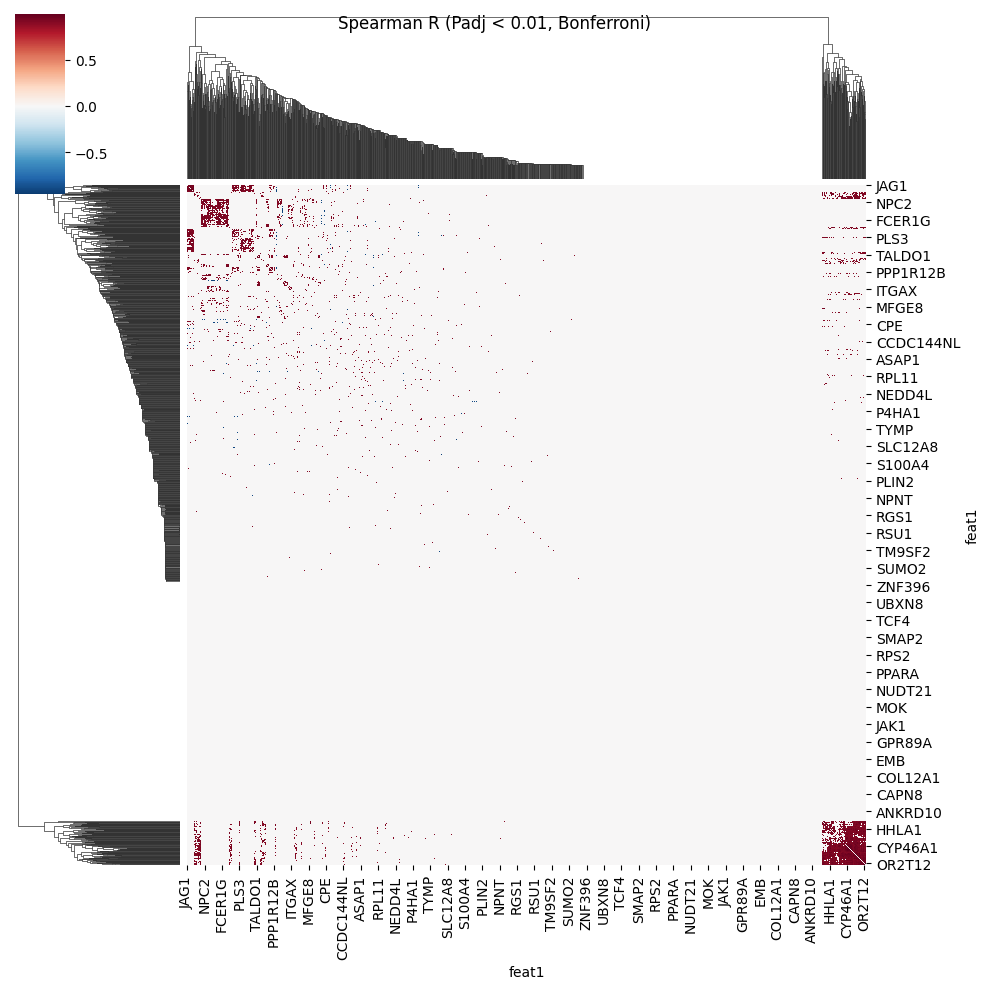

In [ ]:
#Showing only the top correlated features
top_features = rho_fdr.index[(rho_fdr!=0).sum()>0.05*rho_fdr.shape[0]] #top features based on FDR
rho_fdr_top = rho_fdr.copy().loc[top_features,top_features] #subsetting R (fdr corrected) matrix
rho_p_adj_top = rho_p_adj.copy().loc[top_features,top_features] #subsetting R (bonferroni corrected) matrix

g = sns.clustermap(rho_p_adj_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (Padj < 0.01, Bonferroni)');

plt.show()

### Spearman correlation, FDR

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


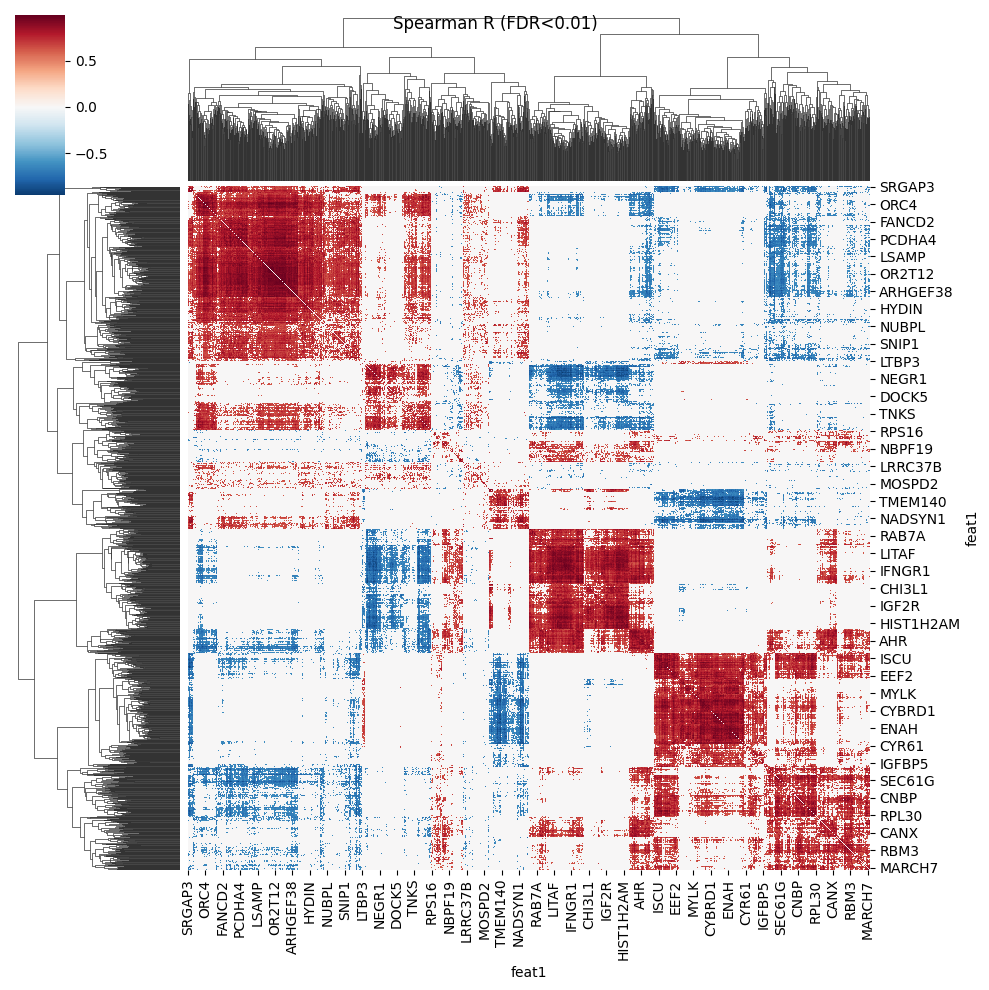

In [ ]:
g = sns.clustermap(rho_fdr_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (FDR<0.01)');
plt.show()

#### **Question**
Did you notice the difference between plots based on Bonferroni correction and FDR?

<details>
<summary>Solution:</summary>

The Bonferroni correction is only selecting very high (absolute) correlations, and remove weak $T_p$. In addition, the negatively-associated features are removed by the Bonferroni correction.
</details>

### Distribution of corr coefficients

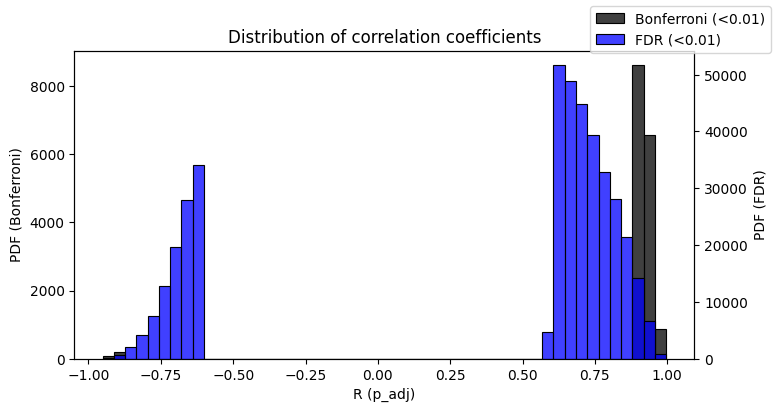

In [ ]:
fig = plt.figure(figsize=(8,4))
p = sns.histplot(rho_p_mat['R (p_adj)'][rho_p_mat['R (p_adj)']!=0], color='black', label='Bonferroni (<0.01)', bins=50);
p.set(ylabel='PDF (Bonferroni)')
ax2 = p.twinx()
g = sns.histplot(rho_p_mat['R (fdr)'][rho_p_mat['R (fdr)']!=0], ax=ax2, color='blue', label='FDR (<0.01)', bins=50);
g.set(ylabel='PDF (FDR)')
fig.legend()
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
plt.show()

# Network construction and preliminary analysis

In [ ]:
# Prepares table for being read by igraph
rho_p_mat = pd.read_csv('association_matrix.tsv', sep="\t")

In [ ]:
rho_p_mat.loc[rho_p_mat['FDR']>0.01,'R (fdr)'] = 0
rho_p_mat = rho_p_mat.loc[rho_p_mat['R (fdr)']!=0,['feat1','feat2','R (fdr)']]
rho_p_mat = rho_p_mat.loc[rho_p_mat.feat1!=rho_p_mat.feat2] #drops self correlations

We are going to build the kNNG based on distances as input to determine the nearest neighbours. Because the data contains both gene expressions and metabolite quantifications, we need to normalize them beforehand.

In [ ]:
#Imports and normalizes met and gene data so that we can compute similarities between them
data = pd.read_csv('https://github.com/Olga013/ds_in_ls/blob/main/presentation/data/met_genes.tsv?raw=true', sep="\t", index_col=0)
scaled_data = pd.DataFrame(StandardScaler().fit_transform(data.loc[:,data.columns!='Type'].T).T, columns=data.columns[data.columns!='Type'], index=data.index)
scaled_data_values = scaled_data.copy()
scaled_data['Type'] = data.Type

In [ ]:
### Generating the kNN graph
#Computes a kNN adjacency matrix from the input dataset
#and prepares table for being read by igraph

input_ds = scaled_data_values.loc[scaled_data_values.index.isin(pd.unique(rho_p_mat[['feat1','feat2']].values.flatten()))]
knnG = sklearn.neighbors.kneighbors_graph(input_ds.values, 200, metric='euclidean')
knnG = pd.DataFrame(knnG.toarray(), columns=input_ds.index.copy(), index=input_ds.index.copy())  #adjacency matrix
knnG.index.name='gene/met1'
knnG.columns.name='gene/met2'
knnG = knnG.stack().reset_index().rename(columns={0:'Connectivity'})
knnG = knnG.loc[knnG['Connectivity']!=0]

#full network, unweighted
edge_list = rho_p_mat.copy().values
all_u = ig.Graph.TupleList([tuple(x) for x in edge_list], directed=False)

#knnG, unweighted
knn = ig.Graph.TupleList([tuple(x) for x in knnG.values], directed=False)

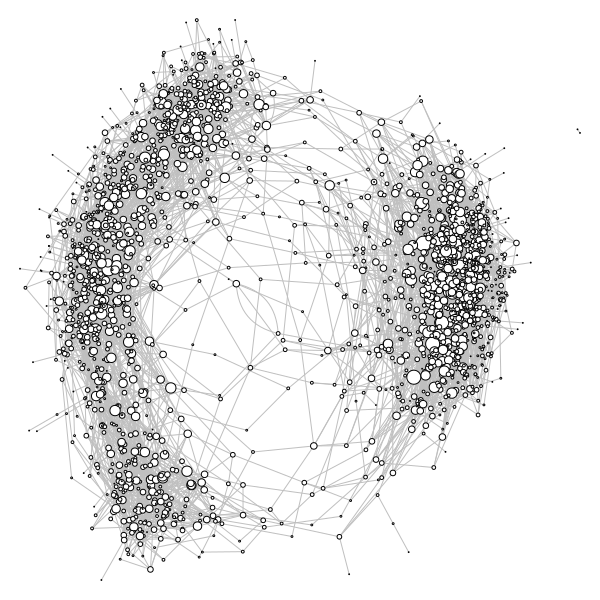

In [ ]:
short_knn = knn_sub_graph(knnG)
ig.plot(short_knn, layout=short_knn.layout_mds(), vertex_color='white', edge_color='silver', vertex_size=short_knn.vs['degree_size'])

In [ ]:
#function to get graph properties, takes a few minutes to run

def graph_prop(input_graph):
    ncount = nn.vcount()
    ecount = nn.ecount()
    diameter = nn.diameter()
    av_path = nn.average_path_length()
    dens = nn.density()
    conn = nn.is_connected()
    min_cut = nn.mincut_value()
    out = pd.DataFrame([ncount, ecount, diameter, av_path, dens, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','connected?','minimum_cut']).T
    return(out)

'''
#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [all_u, knn]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])

network_stats.index=['all_u','knn']
network_stats
'''
#precomputed characteristics
network_stats_ = pd.read_csv('https://github.com/Olga013/ds_in_ls/blob/main/presentation/data/network_stats.csv?raw=true')
network_stats_

Unnamed: 0  node_count  edge_count  diameter  av_path_length   density  \
0      all_u        2105      402368         7        2.122962  0.181700   
1        knn        2105      421000         4        2.318360  0.190114   

   connected?  minimum_cut  
0       False          0.0  
1        True        203.0

# Community analysis (a form of clustering)

We want to find the sets of nodes which have a lot of connections between the members of the set, and few connections to nodes outside of the set.

We will use the [Leiden](https://en.wikipedia.org/wiki/Leiden_algorithm) algorithm using the [Modularity](https://en.wikipedia.org/wiki/Modularity_(networks)) metric, which quantifyes how well our network partitioned into the modules, under the carpet.

Importantly, this method searches for the largest possible communities for our network, which may not always be the desired. Alternative models such as the [Constant Potts Model](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114) allow you to identify smaller communities.

In [ ]:
all_comm = leidenalg.find_partition(all_u, leidenalg.ModularityVertexPartition)
knn_comm = leidenalg.find_partition(knn, leidenalg.ModularityVertexPartition)

In [ ]:
np.round(all_comm.modularity,3)

np.float64(0.427)

In [ ]:
np.round(knn_comm.modularity,3)

np.float64(0.591)

Comparing the different communities by size:

In [ ]:
#Compiles feat lists per community
def get_community_table():
    comm_counts = pd.DataFrame()
    feat_lists = pd.DataFrame()
    for i in [0,1]:
        graph = [all_u,knn][i]
        comm = [all_comm,knn_comm][i]
        name = ['all','knn'][i]
        temp = pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts = pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns = [name]
        comm_counts = pd.concat([comm_counts, counts], axis=1)
        gl = pd.DataFrame(temp.groupby('community')['feat'].apply(list)).reset_index()
        gl['community'] = ['c'+str(i) for i in gl['community']]
        gl['network'] = name
        gl = gl.loc[:,['network','community','feat']]
        feat_lists = pd.concat([feat_lists, gl])

    comm_counts.index = ['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])


bar_data = get_community_table()[0].fillna(0).T

#### **Question**

Some of the communities are very small in the `pos` and full networks, and comprise only 2 and 3 elements. Can we really call this a community?

In [ ]:
bar_data

c1     c2     c3     c4     c5   c6
all  683.0  653.0  612.0  152.0    3.0  2.0
knn  539.0  488.0  464.0  347.0  267.0  0.0

#### Plotting the community sizes:

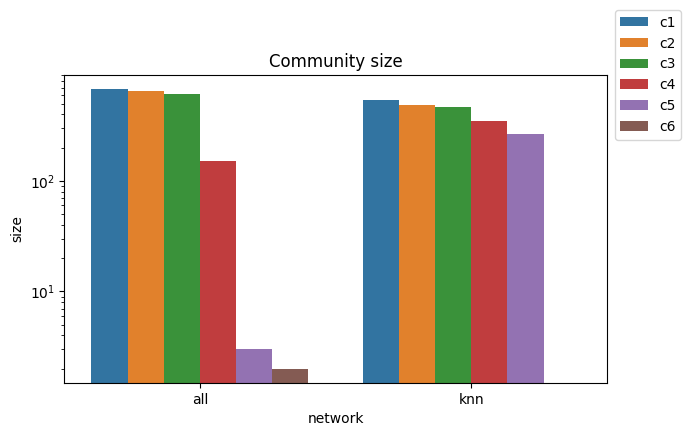

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=bar_data.T.unstack().reset_index().rename(columns={'level_0':'network','level_1':'community',0:'size'}),
    x='network',y='size', hue='community'
           )

ax.set(yscale='log');
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

# Additional analysis

### Centrality analysis of the entire graph

We also can look into different centrality measures and compare the graphs in accordance to them:
- [Degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)) - number of neighbors of a node
- [Betweenness](https://en.wikipedia.org/wiki/Betweenness_centrality) - measures how many shortest paths in the network pass through a node.
- [Closeness](https://en.wikipedia.org/wiki/Centrality#Closeness_centrality) - the average length of the shortest paths between a node and all other nodes
- [Eccentricity](https://en.wikipedia.org/wiki/Distance_(graph_theory)) - largest shortest path from a node to any other node. Nodes with high eccentricity tend to be on the periphery.
- [Eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) - a node is more central if its neighbors show a high degree.
- For oriented graphs [PageRank](https://en.wikipedia.org/wiki/PageRank) and [HITS](https://en.wikipedia.org/wiki/HITS_algorithm).

### Functional analysis of the communities

In order to find the biological meaning in the obtained sets of genes (e.g. found communities), the functional enrichment is usually performed.

In addition, the hypergeometric test or Fisher's test on the genes are used to assess whether they are particularly enriched in specific biological functions or pathways.

[gseapy](https://gseapy.readthedocs.io/en/master/gseapy_example.html#2.-Enrichr-Example) is the library for functional enrichment.

[Here](https://montilab.github.io/BS831/articles/docs/HyperEnrichment.html) you can find the tutorial how to perform the enrichment analysis.

# References

This colab notebook is based on the [tutorial](https://www.benfeitas.net/extras/notebooks/session_topology/lab.html) and the [lecture](https://github.com/NBISweden/workshop_omics_integration/blob/OMICSINT_H24/session_topology/lab/lectures/lecture_short.pdf).

The detecting graph communities as clusters, intro: [video](https://youtu.be/c0_vNfNZ4JM)

Current and future directions in network biology: (https://arxiv.org/pdf/2309.08478)